In [1]:
# To disable `warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)`
import warnings
warnings.filterwarnings('ignore')

## 4. Disciplined Quasiconvex Programming

__Disciplined quasiconvex programming (DQCP)__ is a generalization of DCP for <u>quasiconvex functions</u>.

- $f$ is __quasiconvex__ if and only if its domain and its sublevel sets $S_t=\{x\mid f(x)\leq t\}$ are convex for all $t$.
- $f$ is __quasiconcave__ if $-f$ is quasiconvex.
- $f$ is __quasilinear__ if $f$ is both quasiconvex and quasiconcave.

While DCP is a ruleset for constructing convex programs, DQCP is a ruleset for __quasiconvex programs (QCPs)__.

- The <u>objective</u> of QCP is to minimize a <u>quasiconvex function over a convex set</u>.
- The convex set can be specified using <u>equalities of affine functions</u> and <u>inequalities of convex and concave functions</u>.

Additionally, <u>DQCP permits inequalities</u> of the form

- $f(x)\leq t$, where $f(x)$ is <u>quasiconvex</u> and $t$ is <u>constant</u>, and
- $f(x)\geq t$, where $f(x)$ is <u>quasiconcave</u> and $t$ is <u>constant</u>.

CVXPY lets you form and solve DQCP problems, just as it does for DCP problems.
To solve DQCP problems, you must pass the option `qcp=True` to the `solve()` method.

In [2]:
import cvxpy as cp

x = cp.Variable()
y = cp.Variable(pos=True)

objective = -cp.sqrt(x) / y
prob = cp.Problem(cp.Minimize(objective), [cp.exp(x) <= y])
prob.solve(qcp=True)
assert prob.is_dqcp()

print(f"""
The optimal value is {prob.value:f}.
A solution (x, y) is ({x.value:f}, {y.value:f}).
""")


The optimal value is -0.428882.
A solution (x, y) is (0.499997, 1.648718).



### Curvature

DQCP adds new types of curvature to CVXPY: __quasiconvex__, __quasiconcave__, and __quasilinear__.

CVXPY's curvature analysis can flag Expressions as __unknown__ even when they are quasiconvex or quasiconcave, but it will never mistakenly flag an expression as quasiconvex or quasiconcave.

The curvature of an Expression is stored in its `.curvature` attribute.

In [3]:
x = cp.Variable(3)
y = cp.length(x)
z = -y
w = cp.ceil(x)

x.curvature, y.curvature, z.curvature, w.curvature

('AFFINE', 'QUASICONVEX', 'QUASICONCAVE', 'QUASILINEAR')

You can also check the curvature of an Expression by calling the methods `is_quasiconvex()`, `is_quasiconcave()`, and `is_quasilinear()`.

In [4]:
y.is_quasiconvex(), z.is_quasiconcave(), w.is_quasilinear()

(True, True, True)

### Composition rules

DQCP analysis is based on applying a general composition theorem from convex analysis to each expression.

An expression is verifiably __quasiconvex__ under DQCP if it is one of the following:

- convex (under DCP);
- a quasiconvex atom, applied to a variable or constant:
- the max (`cvxpy.maximum`) of quasiconvex expressions;
- an increasing function of a quasiconvex expression, or a decreasing function of a quasiconcave expression;
- an expression of the form $f(e_1,e_2,\dotsc,e_n)$ such that
    1. $f$ is a quasiconvex atom, and
    2. $f$ is increasing in $x_i$ and $e_i$ is convex, $f$ is decreasing in $x_i$ and $e_i$ is concave, or $e_i$ is affine, for each $i$.

An expression is __quasiconcave__ under DQCP if it is one of the following:

- concave (under DCP);
- a quasiconcave atom, applied to a variable or constant:
- the min (`cvxpy.minimum`) of quasiconcave expressions;
- an increasing function of a quasiconcave expression, or a decreasing function of a quasiconvex expression;
- an expression of the form $f(e_1,e_2,\dotsc,e_n)$ such that
    1. $f$ is a quasiconcave atom, and
    2. $f$ is increasing in $x_i$ and $e_i$ is concave, $f$ is decreasing in $x_i$ and $e_i$ is convex, or $e_i$ is affine, for each $i$.

<u>Whether an atom is quasiconvex or quasiconcave may depend on the signs of its arguments</u>. For example,

- $xy$ is quasiconvex when one of $x$ and $y$ is nonnegative and the other is nonpositive.
- $xy$ is quasiconcave when $x$ and $y$ are either both nonnegative or both nonpositive

In [5]:
x = cp.Variable(nonneg=True)
y = cp.Variable(nonpos=True)

product = cp.multiply(x, y)

product.is_quasiconvex(), product.is_quasiconcave(), product.is_dqcp()

(True, False, True)

In [6]:
x = cp.Variable(nonneg=True)
y = cp.Variable(nonneg=True)

product = cp.multiply(x, y)

product.is_quasiconvex(), product.is_quasiconcave(), product.is_dqcp()

(False, True, True)

If an Expression satisfies the above rules, we say that the Expression "__is DQCP__."

- You can check whether an Expression __is DQCP__ by calling the method `is_dqcp()`.
- An Expression __is DQCP__ precisely when it has known curvature.
- It means at least one of the methods `is_constant()`, `is_affine()`, `is_convex()`, `is_concave()`, `is_quasiconvex()`, `is_quasiconvex()` will return `True`.

### DQCP problems

If a problem follows the DQCP rules, it is guaranteed to be a DQCP and solvable by CVXPY (if a solution to the problem exists).

The DQCP rules require that the problem __objective__ have one of two forms:

- Minimize (quasiconvex)
- Maximize (quasiconcave)

The only valid __constraints__ under the DQCP rules are

- affine `==` affine
- convex `<=` concave
- concave `>=` convex
- quasiconvex `<=` constant
- quasiconcave `>=` constant

You can check that a problem, constraint, or objective satisfies the DQCP rules by calling the method `is_dqcp()`.

CVXPY will raise an exception if you call the method `solve(qcp=True)` on a non-DQCP problem.

In [7]:
# The sign of variables affects curvature analysis.
x = cp.Variable(nonneg=True)
concave_fractional_fn = x * cp.sqrt(x) # quasiconcave
constraint = [cp.ceil(x) <= 10] # ceil is quasilinear
prob = cp.Problem(cp.Maximize(concave_fractional_fn), constraint)

concave_fractional_fn.curvature, constraint[0].is_dqcp(), prob.is_dqcp()

('QUASICONCAVE', True, True)

In [8]:
# Try without the sign "nonneg=True"
w = cp.Variable(nonneg=True)
fn = w * cp.sqrt(w) # quasiconcave
prob = cp.Problem(cp.Maximize(fn))

fn.curvature, fn.is_dqcp(), prob.is_dqcp()

('QUASICONCAVE', True, True)

### DQCP atoms

Quasiconvex and quasiconcave expressions can be constructed using convex and concave atoms, using the curvature rules given above.

We introduces new atoms that are quasiconvex or quasiconcave (but not convex or concave). Many of these new atoms are integer-valued.

#### Ratio

- `x / y` is both __quasiconvex and quasiconcave__ when the denominator is known to be either nonnegative or nonpositive.
- `x / y` is __increasing in__ `x` when `y` is nonnegative, __increasing in__ `y` when `x` is nonpositive, __decreasing in__ `x` when `y` is nonpositive, and __decreasing in__ `y` when `x` is nonnegative.
- The ratio of a nonnegative concave function and a positive convex function is __quasiconcave__.
- The ratio of a nonnegative convex function and a positive concave function is __quasiconvex__.
- The ratio of two affine functions is __quasilinear__ when the denominator is positive.

#### Scalar product

- `x * y` is __quasiconvex__ when one of its arguments is nonnegative and the other is nonpositive.
- `x * y` is __quasiconcave__ when its arguments are both nonnegative or both nonpositive.
- The product of two nonnegative concave functions is __quasiconcave__.
- The product of a nonnegative concave function and a nonpositive convex function is __quasiconvex__.

#### Distance ratio function

- `cvxpy.dist_ratio(x, a, b)` denotes the function $\|x-a\|_2/\|x-b\|_2$.
- This atom is __quasiconvex__.
- It enforces the constraint that $\|x-a\|_2\leq\|x-b\|_2$.
- The expressions `a` and `b` must be constants.

#### Maximum generalized eigenvalue

- `cvxpy.gen_lambda_max(A, B)` computes the maximum generalized eigenvalue of `A` and `B`.
- It is defined as the maximum $\lambda\in\mathbb{R}$ such that $Ax=\lambda Bx$ for some $x$.
- This atom is __quasiconvex__.
- It enforces the constraint that `A` is symmetric and `B` is positive definite.

#### Condition Number

- `cvxpy.condition_number(A)` computes the condition number of `A`.
- It is defined as the $\lambda_\text{max}(A)/\lambda_\text{min}(A)$.
- This atom is __quasiconvex__.
- It enforces the constraint that `A` is symmetric and positive definite.

#### Ceiling and floor

- `cvxpy.ceil(x)` and `cvxpy.floor(x)` are __quasilinear__, and __increasing__ in their arguments.

#### Sign

- `cvxpy.sign(x)` returns `-1` for `x <= 0` and `+1` for `x > 0`.
- This atom is __quasilinear__.

#### Length of a vector

- `cp.length(x)` returns the index of the last nonzero element in $\mathbb{R}^n$.
- This atom is __quasiconvex__.

### Solving DQCP problems

A DQCP problem can be solved by calling the method `solve(qcp=True)`.

CVXPY uses a __bisection method__ on the optimal value of the problem to solve QCPs.

- It will automatically find an upper and lower bound for the bisection.
- You can optionally provide your own upper and lower bound when solving a QCP, which can sometimes be helpful.
- For example, `solve(qcp=True, low=12, high=17)` would limit the bisection to objective values that are greater than 12 and less than 17.

Bisection involves solving a sequence of optimization problems.

- If your problem is ill-conditioned, or if you’re unlucky, a solver might fail to solve one of these subproblems, which will result in an error.
- If this happens, you can try using a different solver via the `solver` keyword argument. For example, `solve(qcp=True, solver=cp.SCS)`.
- [__SCS__](https://github.com/cvxgrp/scs) (Splitting Conic Solver) is a numerical optimization package for solving large-scale convex cone problems, which is included in CVXPY.

To obtain verbose output describing the bisection, supply the keyword argument `verbose=True` to the solve method. For example, `solve(qcp=True, verbose=True)`.

## Examples

### Concave fractional optimization

The objective of __concave fractional problem__ is to maximize the ratio of a nonnegative concave function and a positive convex function.
Concave fractional problems are __quasiconvex programs (QCPs)__.

Our goal is to maximize $\dfrac{\sqrt{x}}{e^x}$. This function is not concave, but it is __quasiconcave__ (actually, __quasilinear__).

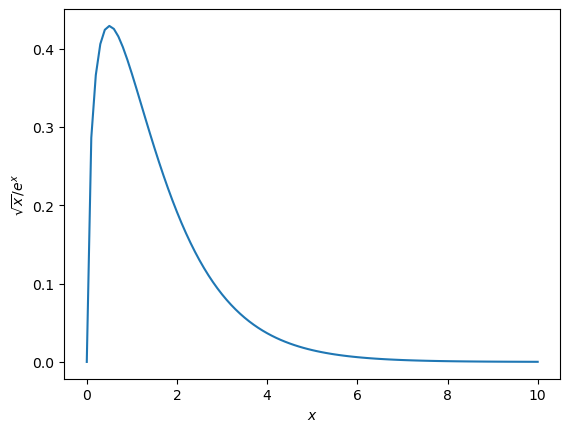

In [9]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

x = np.linspace(0, 10, num=101)
y = np.sqrt(x) / np.exp(x)

_, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("$x$")
ax.set_ylabel("$\sqrt{x}/e^x$");

In [10]:
x = cp.Variable()
prob = cp.Problem(cp.Maximize(cp.sqrt(x) / cp.exp(x)))
assert prob.is_dqcp()
prob.solve(qcp=True)

print(f"""
The optimal value is {prob.value:f}
A solution is {x.value:f}
""")


The optimal value is 0.428882
A solution is 0.500002



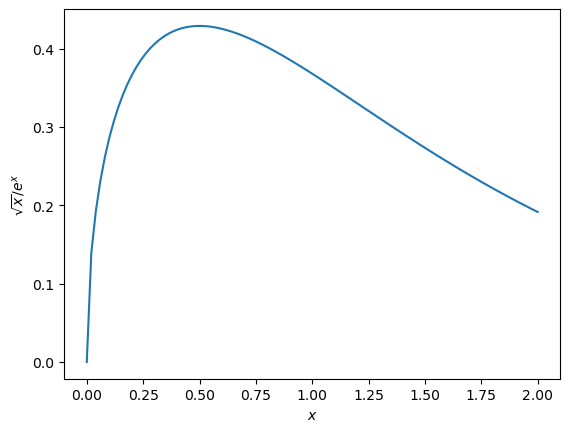

In [11]:
x = np.linspace(0, 2, num=101)
y = np.sqrt(x) / np.exp(x)

_, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("$x$")
ax.set_ylabel("$\sqrt{x}/e^x$");

### Minimum-length least squares

Recall that `cp.length(x)` returns the index of the last nonzero element in $\mathbb{R}^n$.

A __minimum-length least squares problem__ finds a minimum-length vector achieving small mean-square error (MSE) for a particular least squares problem
$$
\begin{align*}
\text{minimize} &\qquad \operatorname{len}(x) \\
\text{subject to} &\qquad \frac{\|Ax-b\|_2^2}{n} \leq \epsilon,
\end{align*}
$$
where $n$, $A$, $b$, and $\epsilon$ are the problem data, and $x$ is the problem variable.

This is a __quasiconvex program (QCP)__.

In [12]:
import numpy as np
import cvxpy as cp

n = 10

rng = np.random.default_rng(1)

x_star = rng.standard_normal(n)
A = rng.standard_normal((n, n))
b = A @ x_star
epsilon = 1e-2

x = cp.Variable(n)
mse = cp.sum_squares(A @ x - b) / n
prob = cp.Problem(
    cp.Minimize(cp.length(x)), [mse <= epsilon]
)
assert prob.is_dqcp()
prob.solve(qcp=True)

print(f"""
An optimal value is {prob.value}
A solution is {x.value}
x_star is {x_star}
MSE is {mse.value}    
""")


An optimal value is 8.0
A solution is [ 2.02671669e-01  5.13387830e-01  7.17486951e-01 -1.50132021e+00
  9.34419350e-01  6.23763505e-01 -1.62427345e+00  6.54650603e-01
 -6.94751306e-17 -1.58546071e-16]
x_star is [ 0.34558419  0.82161814  0.33043708 -1.30315723  0.90535587  0.44637457
 -0.53695324  0.5811181   0.3645724   0.2941325 ]
MSE is 0.0007399337899782794    



### Aerospace Design via Quasiconvex Optimization

Consider a triangle, or a wedge, located within a hypersonic(초음속) flow.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/Airfoil_lift_and_drag.svg/390px-Airfoil_lift_and_drag.svg.png)

A standard __aerospace design optimization problem__ is to design the wedge to <u>maximize the lift-to-drag ratio</u> $L/D$ subject to certain geometric constraints.

In this example, the wedge is known to have a <u>constant hypotenuse</u>, and our job is to choose its width and height.

The __drag-to-lift ratio__ is given by $\dfrac{D}{L} = \dfrac{c_d}{c_l}$, where $c_d$ and $c_l$ are __drag and lift coefficients__, respectively, that are obtained by integrating the projection of the __pressure coefficient__ in directions parallel to, and perpendicular to, the body.
$$
c_d = \frac{1}{c}\int_0^s-c_p\hat n_x\,ds = -\frac{s}{c} c_p\hat n_x \quad\text{and}\quad
c_l = \frac{1}{c}\int_0^s-c_p\hat n_y\,ds = -\frac{s}{c} c_p\hat n_y
$$
where $c$ is the reference chord length of the body.

- We assume the pressure coefficient is given by the Newtonian sine-squared law for wetted areas (the surface area that interacts with the working fluid) of the body $c_p = 2(\hat v\cdot\hat n)^2$ and elsewhere $c_p=0$.
- We assume the free stream direction is parallel to the body so that $\hat v=\langle 1,0\rangle$.
- For a wedge defined by width $\Delta x$, height $\Delta y$, and the hypotenuse length $s$, the local unit normal is $\hat n=\langle -\frac{\Delta y}{s},-\frac{\Delta x}{s} \rangle$.

Assuming $s=1$, so that $\Delta y=\sqrt{1-(\Delta x)^2}$, we obtain the __objective__ function
$$
\frac{D}{L} = \frac{\Delta y}{\Delta x} = \frac{\sqrt{1-(\Delta x)^2}}{\Delta x} = \sqrt{\frac{1}{(\Delta x)^2}-1}.
$$. 
<u>This function is representable as a DQCP, quasilinear function</u>.

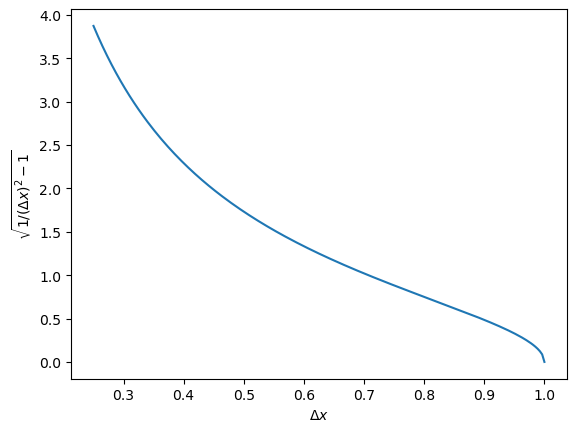

In [13]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0.25, 1, num=201)
y = [np.sqrt(1. / xi**2 - 1) for xi in x]

_, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("$\Delta x$")
ax.set_ylabel("$\sqrt{1/(\Delta x)^2 - 1}$");

Minimizing this objective function subject to constraints representing payload requirements is a standard aerospace design problem.

In this case we will consider the __constraint__ that <u>the wedge must be able to contain a rectangle of given length and width internally along its hypotenuse</u>.
$$
\frac{a}{\Delta x} - (1-b)\Delta y \leq 0
$$
This is representable as a convex constraint.

In [14]:
import cvxpy as cp

x = cp.Variable(pos=True)
objective = cp.sqrt(cp.inv_pos(cp.square(x)) - 1)

a = .05 # USER INPUT: height of rectangle, should be at most b
b = .65 # USER INPUT: width    of rectangle
constraint = [
    a * cp.inv_pos(x) - (1 - b) * cp.sqrt(1 - cp.square(x)) <= 0
]
objective, constraint

(Expression(QUASILINEAR, NONNEGATIVE, ()),
 [Inequality(Expression(CONVEX, UNKNOWN, ()))])

### BUG

There is an issue in the `dqcp2dcp` reduction.

https://github.com/cvxpy/cvxpy/issues/2165

In [15]:
prob = cp.Problem(cp.Minimize(objective), constraint)
prob.solve(qcp=True, verbose=True)

print(f"""
Final L/D Ratio = {objective.value:f}
Final width of wedge = {x.value:f}
Final height of wedge = {np.sqrt(1 - x.value**2):f}
""")

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Apr 01 11:19:00 AM: Your problem has 1 variables, 1 constraints, and 0 parameters.
(CVXPY) Apr 01 11:19:00 AM: It is compliant with the following grammars: DQCP
(CVXPY) Apr 01 11:19:00 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 01 11:19:00 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 01 11:19:00 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Apr 01 11:19:00 AM: Reducing DQCP problem to a one-parameter family of DCP problems, for bisection.

********************************************************************************
Preparing to bisect problem

minimize 0.0
subject to 0.05 @ var2884 + -0.35 @ var2911 <= 0.0
           SOC(reshape(var2865 + va

Once the solution has been found, we can create a plot to verify that the rectangle is inscribed within the wedge.

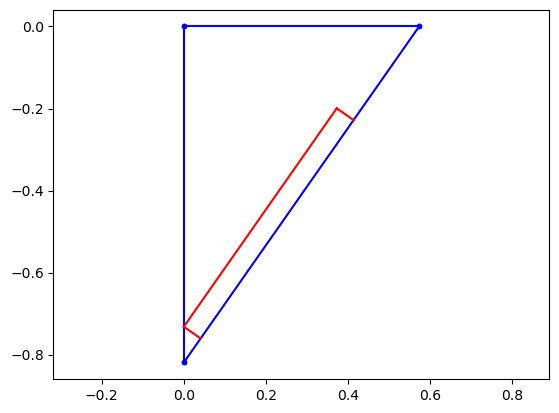

In [16]:
dx = x.value
dy = np.sqrt(1 - dx**2)

_, ax = plt.subplots()
ax.plot([0, dx], [0, 0], "b.-") # horizontal line
ax.plot([0, 0], [0, -dy], "b.-") # vertical line
ax.plot([0, dx], [-dy, 0], "b.-") # hypotenus

P0 = np.array([0, -(dy - a / dx)])
P1 = P0 + b * np.array([dx, dy])
P2 = P0 + a * np.array([dy, -dx])
P3 = P1 + a * np.array([dy, -dx])

ax.plot([P0[0], P1[0]], [P0[1], P1[1]], "r-")
ax.plot([P0[0], P2[0]], [P0[1], P2[1]], "r-")
ax.plot([P1[0], P3[0]], [P1[1], P3[1]], "r-")

ax.axis("equal");